In [1]:
import pandas as pd
import numpy as np
import string
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

df = pd.read_csv("../data/fulldata.csv")
df2 = pd.read_csv("../data/6_14_pull.csv")

df = pd.concat([df,df2])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
from Cleaning import lowercase, unpunctuate, tokenize, lemmatize, count_capitalized_words, create_other_var, cleaning_and_prep, stack_vectors

In [3]:
X_train, X_test, y_train, y_test = cleaning_and_prep(df)

C:\Users\Andrew\Documents\LHL\PoliticalNLP\python\Cleaning.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Political Lean'] = df['Political Lean'].replace('Liberal',1)
C:\Users\Andrew\Documents\LHL\PoliticalNLP\python\Cleaning.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Political Lean'] = df['Political Lean'].replace('Conservative',0)


In [4]:
X_train_vec, X_test_vec, X_train, X_test, scaler = stack_vectors(X_train,X_test)

Epoch 1/150
376/376 [==============================] - 6s 10ms/step - loss: 0.5970 - accuracy: 0.6656 - auc: 0.7384 - val_loss: 0.5666 - val_accuracy: 0.7094 - val_auc: 0.7885
Epoch 2/150
376/376 [==============================] - 3s 9ms/step - loss: 0.5586 - accuracy: 0.7029 - auc: 0.7815 - val_loss: 0.5630 - val_accuracy: 0.7094 - val_auc: 0.7914
Epoch 3/150
376/376 [==============================] - 3s 9ms/step - loss: 0.5486 - accuracy: 0.7097 - auc: 0.7911 - val_loss: 0.5578 - val_accuracy: 0.7075 - val_auc: 0.7961
Epoch 4/150
376/376 [==============================] - 3s 9ms/step - loss: 0.5434 - accuracy: 0.7142 - auc: 0.7956 - val_loss: 0.5471 - val_accuracy: 0.7228 - val_auc: 0.8051
Epoch 5/150
376/376 [==============================] - 3s 9ms/step - loss: 0.5379 - accuracy: 0.7172 - auc: 0.8007 - val_loss: 0.5512 - val_accuracy: 0.7091 - val_auc: 0.8029
Epoch 6/150
376/376 [==============================] - 3s 9ms/step - loss: 0.5346 - accuracy: 0.7209 - auc: 0.8030 - val_los

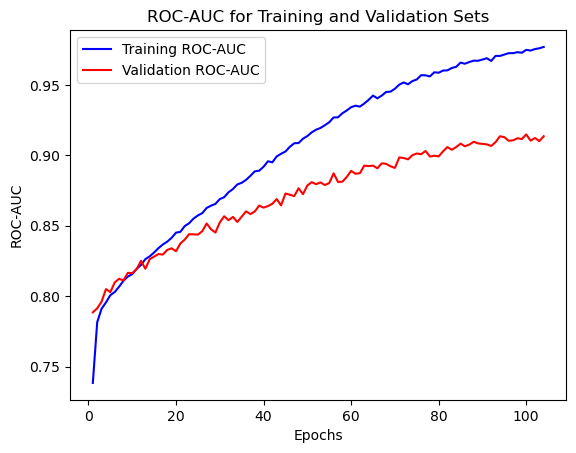

<Axes: >

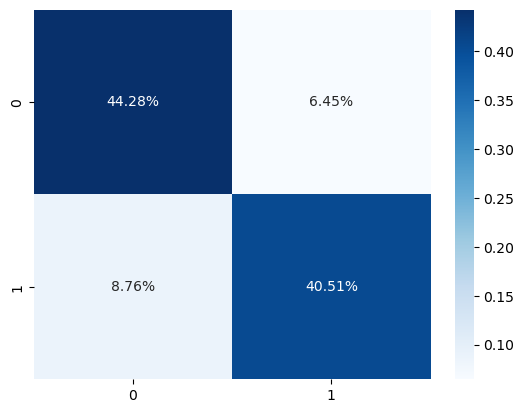

In [5]:
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Input, concatenate
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

dropout=0.05
lstm_units = 256
lstm_units2 = 128
dense_units = 64


# First branch for the LSTM
lstm_input = Input(shape=(1, 100))
lstm_output = LSTM(units=lstm_units, return_sequences=True, activation='relu')(lstm_input)
lstm_output = Dropout(dropout)(lstm_output)
lstm_output = LSTM(units=lstm_units2, activation='relu')(lstm_output)
lstm_output = Dropout(dropout)(lstm_output)

# Second branch for the dense layers
dense_input = Input(shape=(5,))
dense_output = Dense(units=dense_units, activation='relu')(dense_input)
dense_output = Dropout(dropout)(dense_output)

# Concatenate the outputs from both branches
combined = concatenate([lstm_output, dense_output])

combined = Dense(units = dense_units, activation='relu')(combined)

# Final output layer
output = Dense(units=1, activation='sigmoid')(combined)

# Create the model
model = Model(inputs=[lstm_input, dense_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model with both LSTM and dense input
history = model.fit([X_train_vec, X_train], y_train, epochs=150, batch_size=64,
          validation_data=([X_test_vec, X_test], y_test),
          callbacks=[early_stopping])

# Predict and evaluate
y_pred = model.predict([X_test_vec, X_test])
roc_auc = roc_auc_score(y_test, y_pred)

y_pred_class = (y_pred > .5).astype(int)
accuracy = accuracy_score(y_test,y_pred_class)
print('ROC-AUC:', roc_auc)
print('Accuracy:', accuracy)

# Get the ROC-AUC values for training and validation sets
train_roc_auc = history.history['auc']
val_roc_auc = history.history['val_auc']

# Plot ROC-AUC for training and validation sets
epochs = range(1, len(train_roc_auc) + 1)

plt.plot(epochs, train_roc_auc, 'b', label='Training ROC-AUC')
plt.plot(epochs, val_roc_auc, 'r', label='Validation ROC-AUC')
plt.title('ROC-AUC for Training and Validation Sets')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(y_test, y_pred_class)

sns.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%', cmap='Blues')

In [6]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

#create extra variables for later
df_other_var = create_other_var(df)

#Create simple dataframe with only text and predictor
df = df[['Title','Political Lean']] 

#dummy code predictor
df['Political Lean'] = df['Political Lean'].replace('Liberal',1)
df['Political Lean'] = df['Political Lean'].replace('Conservative',0)

df = df.rename({'Political Lean':'y'},axis=1) #replace column name for simplicity

df = pd.concat([df,df_other_var],axis=1)

df = df[df['Length']>=15]

#Split into X & y
X = df.drop(['y'],axis=1)
y = df['y']

#oversample minority class
oversample = RandomOverSampler(sampling_strategy='minority', random_state=13)
X, y = oversample.fit_resample(X, y)
X, y = shuffle(X,y, random_state=13)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X,y, test_size=.15, random_state = 13)

In [9]:
predictions = pd.DataFrame(y_pred, columns = ['prob'])
loss_df = pd.concat([X_test_text,predictions.set_index(X_test_text.index)],axis=1)
loss_df = pd.concat([loss_df,y_test_text],axis=1)
loss_df['prob'] = abs(loss_df['prob']-.5)

In [13]:
#dropping duplicates due to oversampling
pd.set_option('display.max_colwidth', None)
loss_df.drop_duplicates(subset='Title').sort_values(by='prob').tail(50)

,Title,Upvotes,Comments,Length,Capitals,prob,y
2876,Republicans Won't Be Elected If Democrats Pass Voting Bill: Trump,932,227,65,10,0.5,1
19443,Get ready for the Red Mirage on election night in Pennsylvania.,254,63,63,4,0.5,1
22585,MTG Says Bribery Allegations Against Biden Linked To Burisma,15,1,60,9,0.5,0
20227,"Trump Says He's Been Indicted, Will Appear in Court Tuesday",6,1,59,9,0.5,0
16114,Republicans Plan Debt-Limit Crisis to Force Cuts to Medicare and Social Security,158,25,80,10,0.5,1
5068,Am I a social democrat?,21,16,23,1,0.5,1
3635,Sen. Rand Paul eviscerated after accusing Democrats of ‘stealing’ elections by mobilizing voters,818,41,96,4,0.5,1
4950,Just shut it down then,2060,28,22,1,0.5,1
12611,𝖱𝖾𝗆𝗂𝗇𝖽𝖾𝗋 𝗍𝗁𝖺𝗍 𝖻𝗅𝖺𝖼𝗄 𝗌𝗎𝗉𝗋𝖾𝗆𝖺𝖼𝗂𝗌𝗍𝗌 𝖺𝗋𝖾 𝗌𝗍𝗂𝗅𝗅 𝗍𝖾𝖺𝖼𝗁𝗂𝗇𝗀 𝖺𝗇𝗍𝗂-𝗐𝗁𝗂𝗍𝖾 𝗋𝖺𝖼𝗂𝗌𝗆 𝗂𝗌 𝗉𝖺𝗋𝗍 𝗈𝖿 𝗌𝖼𝗁𝗈𝗈𝗅 𝖼𝗎𝗋𝗋𝗂𝖼𝗎𝗅𝗎𝗆𝗌. 𝖠𝗇𝖽 𝗂𝗍'𝗌 𝗃𝗎𝗌𝗍 𝖺𝗌 𝖻𝖺𝖽 𝖺𝗌 𝗂𝖿 𝗍𝗁𝖾 𝖪𝖪𝖪 𝗐𝖺𝗌 𝗍𝖾𝖺𝖼𝗁𝗂𝗇𝗀 𝗐𝗁𝗂𝗍𝖾 𝗌𝗎𝗉𝗋𝖾𝗆𝖺𝖼𝗒,44,3,164,0,0.5,0
17923,Clarence Thomas’s problems multiply at Supreme Court,505,52,52,4,0.5,1
